使用变分自编码器生成MNIST数据
===

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_features = 784
num_hidden_1 = 500
num_latent = 15

Device: cuda:0


# 2.导入数据

In [3]:
train_dataset = datasets.MNIST(root='/input/MNIST/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='/input/MNIST/', 
                              train=False, 
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# 3.模型

In [4]:
class VariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_latent):
        super(VariationalAutoencoder, self).__init__()
        
        ### ENCODER
        self.hidden_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.z_mean = torch.nn.Linear(num_hidden_1, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(num_hidden_1, num_latent)
        
        
        ### DECODER
        self.linear_3 = torch.nn.Linear(num_latent, num_hidden_1)
        self.linear_4 = torch.nn.Linear(num_hidden_1, num_features)

    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features):
        x = self.hidden_1(features)
        x = F.leaky_relu(x, negative_slope=0.0001)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded):
        x = self.linear_3(encoded)
        x = F.leaky_relu(x, negative_slope=0.0001)
        x = self.linear_4(x)
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features):
        
        z_mean, z_log_var, encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = VariationalAutoencoder(num_features,
                               num_hidden_1,
                               num_latent)
model = model.to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# 4.训练

In [6]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/469 | Cost: 16576.1523
Epoch: 001/050 | Batch 050/469 | Cost: 15458.1445
Epoch: 001/050 | Batch 100/469 | Cost: 15653.8682
Epoch: 001/050 | Batch 150/469 | Cost: 15715.1250
Epoch: 001/050 | Batch 200/469 | Cost: 15151.5000
Epoch: 001/050 | Batch 250/469 | Cost: 15320.6787
Epoch: 001/050 | Batch 300/469 | Cost: 15401.7305
Epoch: 001/050 | Batch 350/469 | Cost: 15628.7930
Epoch: 001/050 | Batch 400/469 | Cost: 14796.6816
Epoch: 001/050 | Batch 450/469 | Cost: 15029.7148
Time elapsed: 0.21 min
Epoch: 002/050 | Batch 000/469 | Cost: 14466.5225
Epoch: 002/050 | Batch 050/469 | Cost: 14488.0674
Epoch: 002/050 | Batch 100/469 | Cost: 14374.9961
Epoch: 002/050 | Batch 150/469 | Cost: 13931.6299
Epoch: 002/050 | Batch 200/469 | Cost: 15041.7178
Epoch: 002/050 | Batch 250/469 | Cost: 14671.1602
Epoch: 002/050 | Batch 300/469 | Cost: 14323.0410
Epoch: 002/050 | Batch 350/469 | Cost: 14310.5498
Epoch: 002/050 | Batch 400/469 | Cost: 14483.9336
Epoch: 002/050 | Batch 450/

Epoch: 016/050 | Batch 350/469 | Cost: 13273.7129
Epoch: 016/050 | Batch 400/469 | Cost: 13870.1748
Epoch: 016/050 | Batch 450/469 | Cost: 13226.7891
Time elapsed: 3.33 min
Epoch: 017/050 | Batch 000/469 | Cost: 13056.9658
Epoch: 017/050 | Batch 050/469 | Cost: 13545.5166
Epoch: 017/050 | Batch 100/469 | Cost: 12821.4814
Epoch: 017/050 | Batch 150/469 | Cost: 13641.3848
Epoch: 017/050 | Batch 200/469 | Cost: 13286.2891
Epoch: 017/050 | Batch 250/469 | Cost: 13447.4473
Epoch: 017/050 | Batch 300/469 | Cost: 13271.9844
Epoch: 017/050 | Batch 350/469 | Cost: 13497.6348
Epoch: 017/050 | Batch 400/469 | Cost: 13319.1426
Epoch: 017/050 | Batch 450/469 | Cost: 13427.1445
Time elapsed: 3.54 min
Epoch: 018/050 | Batch 000/469 | Cost: 13327.5020
Epoch: 018/050 | Batch 050/469 | Cost: 13367.0098
Epoch: 018/050 | Batch 100/469 | Cost: 12953.6709
Epoch: 018/050 | Batch 150/469 | Cost: 13375.8398
Epoch: 018/050 | Batch 200/469 | Cost: 13395.6699
Epoch: 018/050 | Batch 250/469 | Cost: 13785.7529
Epoc

Epoch: 032/050 | Batch 200/469 | Cost: 13011.9199
Epoch: 032/050 | Batch 250/469 | Cost: 13039.2949
Epoch: 032/050 | Batch 300/469 | Cost: 12879.8027
Epoch: 032/050 | Batch 350/469 | Cost: 13548.0713
Epoch: 032/050 | Batch 400/469 | Cost: 13059.1748
Epoch: 032/050 | Batch 450/469 | Cost: 13298.2822
Time elapsed: 6.66 min
Epoch: 033/050 | Batch 000/469 | Cost: 12998.9238
Epoch: 033/050 | Batch 050/469 | Cost: 12956.7178
Epoch: 033/050 | Batch 100/469 | Cost: 13300.2227
Epoch: 033/050 | Batch 150/469 | Cost: 13344.6758
Epoch: 033/050 | Batch 200/469 | Cost: 13352.0508
Epoch: 033/050 | Batch 250/469 | Cost: 13120.9609
Epoch: 033/050 | Batch 300/469 | Cost: 13225.7861
Epoch: 033/050 | Batch 350/469 | Cost: 13253.5781
Epoch: 033/050 | Batch 400/469 | Cost: 12803.5078
Epoch: 033/050 | Batch 450/469 | Cost: 12845.1973
Time elapsed: 6.87 min
Epoch: 034/050 | Batch 000/469 | Cost: 12741.1562
Epoch: 034/050 | Batch 050/469 | Cost: 12515.2275
Epoch: 034/050 | Batch 100/469 | Cost: 12320.8613
Epoc

Epoch: 048/050 | Batch 050/469 | Cost: 12749.6445
Epoch: 048/050 | Batch 100/469 | Cost: 13181.0996
Epoch: 048/050 | Batch 150/469 | Cost: 12807.1953
Epoch: 048/050 | Batch 200/469 | Cost: 12833.0859
Epoch: 048/050 | Batch 250/469 | Cost: 13221.9434
Epoch: 048/050 | Batch 300/469 | Cost: 12897.3965
Epoch: 048/050 | Batch 350/469 | Cost: 13057.0928
Epoch: 048/050 | Batch 400/469 | Cost: 12980.5898
Epoch: 048/050 | Batch 450/469 | Cost: 12755.5576
Time elapsed: 10.00 min
Epoch: 049/050 | Batch 000/469 | Cost: 12804.4463
Epoch: 049/050 | Batch 050/469 | Cost: 12776.6719
Epoch: 049/050 | Batch 100/469 | Cost: 12721.2188
Epoch: 049/050 | Batch 150/469 | Cost: 13364.2881
Epoch: 049/050 | Batch 200/469 | Cost: 13705.1299
Epoch: 049/050 | Batch 250/469 | Cost: 12195.6885
Epoch: 049/050 | Batch 300/469 | Cost: 13227.5840
Epoch: 049/050 | Batch 350/469 | Cost: 12993.2363
Epoch: 049/050 | Batch 400/469 | Cost: 13098.4277
Epoch: 049/050 | Batch 450/469 | Cost: 13240.9355
Time elapsed: 10.21 min
Ep

# 5.评估

## 5.1.重构

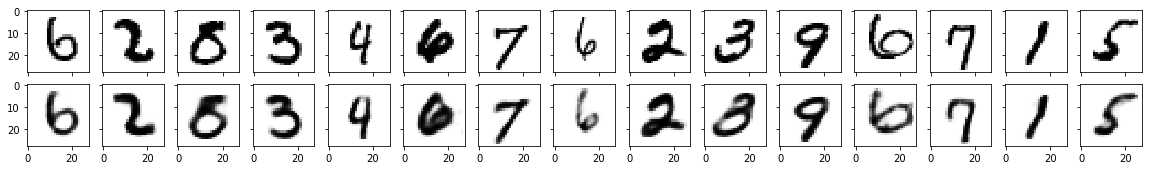

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

## 5.2.生成

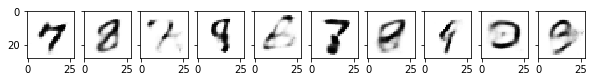

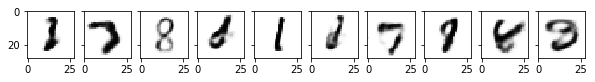

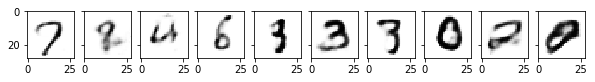

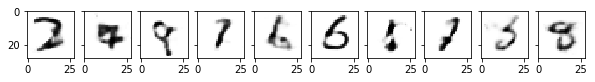

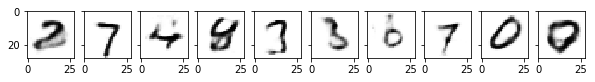

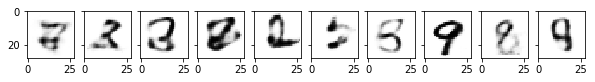

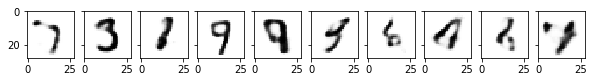

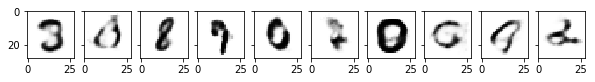

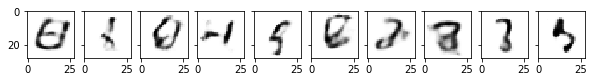

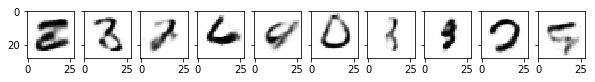

In [9]:
for i in range(10):

    ##########################
    ### RANDOM SAMPLE
    ##########################    
    
    n_images = 10
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features)

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images]

    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)), cmap='binary')